### Let's start by importing all the necessary modules to work in our project.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
%matplotlib inline

In [2]:
df = pd.read_excel("default of credit card clients.xls",header=1,sep='\t')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [3]:
df.rename(columns={'default payment next month':'DEFAULT'},inplace=True)
df.drop(columns=['ID'],inplace=True)

In [6]:
print(df['SEX'].unique())

print(df['MARRIAGE'].unique())

print(df['EDUCATION'].unique())

[2 1]
[1 2 3 0]
[2 1 3 5 4 6 0]


In [10]:
# Suppose 0 in MARRIAGE and EDUCATION is missing data and we want to remove it
print(len(df.loc[ (df['EDUCATION']==0) | (df['MARRIAGE']==0) ]))

df = df.loc[ (df['EDUCATION']!=0) & (df['MARRIAGE']!=0) ]

0


- Let's downsample the data now since SVM can become quite computationally prohibitive on large datasets

In [13]:
df_no_default = df[df['DEFAULT']==0]
df_default    = df[df['DEFAULT']==1]

In [14]:
df_no_default_downsampled = resample(df_no_default,replace=False,n_samples=1000,random_state=42)
df_default_downsampled    = resample(df_default,replace=False,n_samples=1000,random_state=42)

len(df_default_downsampled)

1000

In [15]:
df_downsample = pd.concat([df_no_default_downsampled,df_default_downsampled],ignore_index=True)
len(df_downsample)

2000

Start split data for implementing the model

In [16]:
X = df_downsample.drop('DEFAULT',axis=1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
1,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
2,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
3,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
4,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [17]:
y = df_downsample['DEFAULT'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: DEFAULT, dtype: int64


### Format Data Part 2 - One Hot Encoding

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler

In [26]:
categorical_features = list(X.columns[[2,3,4,6,7,8,9,10,11]])
categorical_transformer = Pipeline( steps=[ ('onehot',OneHotEncoder(handle_unknown='ignore')) ] )

In [27]:
numerical_features = list(X.columns.difference([2,3,4,6,7,8,9,10,11]))
numerical_transformer = Pipeline(steps= [('scaler',StandardScaler())])

In [28]:
preprocessor = ColumnTransformer(transformers=[
    ('cat',categorical_transformer,categorical_features),
    ('num',numerical_transformer,numerical_features),
])

In [29]:
clf_svm = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('SVC',SVC())
])

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [31]:
clf_svm.fit(X_train,y_train);

In [32]:
from sklearn import set_config
set_config(display='diagram')
clf_svm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EDUCATION', 'MARRIAGE',
                                                   'AGE', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6',
                                                   'BILL_AMT1']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'BILL_AMT1',
                                                   'BILL_AMT2', 'BILL_AMT3',
                                                   'BILL_AMT4', 'BILL_AMT5',
                                                   'BILL_AMT6', 'EDUCATION',
                                                   'LIMIT_BAL', 'MARRIAGE',
                                                   'PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6',
                                                   'SEX'])])),
                ('SVC', SVC())])

In [33]:
set_config(display='text')

### Ok, we've built a Support Vector Machine for classification. Let's see how it performs on the Testing Dataset and draw a confusion matrix

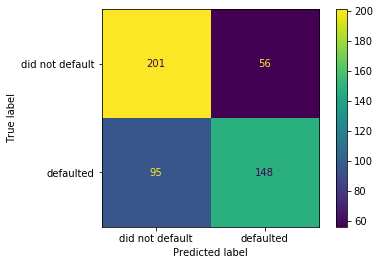

In [34]:
plot_confusion_matrix(clf_svm,X_test,y_test,display_labels=['did not default','defaulted']);

In [35]:
param_grid = {'SVC__C':[0.1,1,10,100,1000],
             'SVC__gamma':['auto','scale',1,0.1,0.01,0.001,0.0001],
             'SVC__kernel':['rbf']
             }

grid_search = GridSearchCV(clf_svm,param_grid,cv=10,verbose=3,n_jobs=-1)

In [36]:
grid_search.fit(X_train,y_train);

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   11.6s finished


In [37]:
grid_search.best_params_

{'SVC__C': 100, 'SVC__gamma': 0.001, 'SVC__kernel': 'rbf'}

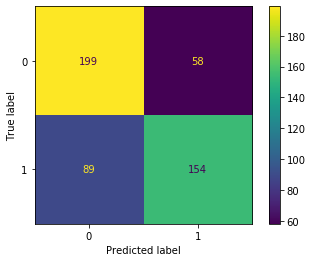

In [38]:
plot_confusion_matrix(grid_search,X_test,y_test);